## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0 "
# 只使用 60% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 TensorFlow Session
tf.keras.backend.set_session(sess)

Using TensorFlow backend.
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tenso

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)#加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)#加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3  #學習率
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024  #訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.05,0.5,0.99,]
redice_lr_patient = [5,10,15]

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, #學習速率被降低的因數。新的學習速率=學習速率*因數
                              min_lr=1e-12, #學習速率的下邊界。
                              monitor='val_loss', #被監測的數據
                              patience=reduce_patient, #沒有進步的訓練輪數，在這之後訓練速率會被降低
                              verbose=1)  #訊息展示模式，0或1。0：安静，1：更新信息。
    
    model.fit(x_train, y_train, #訓練資料。
              epochs=EPOCHS, #訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=BATCH_SIZE,  #訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test), #驗證資料。
              shuffle=True,#每次epochs後，將訓練集打亂順序。
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.05, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
b

50000/50000 [==============================] - 3s 53us/step - loss: 1.9686 - accuracy: 0.3277 - val_loss: 1.9442 - val_accuracy: 0.3202
Epoch 9/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.9359 - accuracy: 0.3367 - val_loss: 1.9276 - val_accuracy: 0.3280
Epoch 10/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.9104 - accuracy: 0.3446 - val_loss: 1.9160 - val_accuracy: 0.3362
Epoch 11/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.8847 - accuracy: 0.3521 - val_loss: 1.9043 - val_accuracy: 0.3422
Epoch 12/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.8634 - accuracy: 0.3579 - val_loss: 1.8958 - val_accuracy: 0.3474
Epoch 13/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.8429 - accuracy: 0.3637 - val_loss: 1.8880 - val_accuracy: 0.3475
Epoch 14/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.8243 - accuracy: 0.3691 - val_loss: 1.8796 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 66us/step - loss: 2.6937 - accuracy: 0.1513 - val_loss: 2.2603 - val_accuracy: 0.1576
Epoch 2/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.3848 - accuracy: 0.2185 - val_loss: 2.1783 - val_accuracy: 0.2131
Epoch 3/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.2354 - accuracy: 0.2530 - val_loss: 2.1144 - val_accuracy: 0.2409
Epoch 4/25
50000/50000 [==============================] - 3s 54us/step - loss: 2.1435 - accuracy: 0.2756 - val_loss: 2.0547 - val_accuracy: 0.2628
Epoch 5/25
50000/50000 [==============================] - 3s 56us/step - loss: 2.0769 - accuracy: 0.2919 - val_loss: 2.0063 - val_accuracy: 0.2793
Epoch 6/25
50000/50000 [==============================] - 3s 59us/step - loss: 2.0275 - accuracy: 0.3075 - val_loss: 1.9709 - val_accuracy: 0.2933
Epoch 7/25
50000/50000 [==============================] - 3s 58us/st

Epoch 21/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.7225 - accuracy: 0.3983 - val_loss: 1.8022 - val_accuracy: 0.3733
Epoch 22/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.7119 - accuracy: 0.4036 - val_loss: 1.7943 - val_accuracy: 0.3753
Epoch 23/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.7023 - accuracy: 0.4055 - val_loss: 1.7864 - val_accuracy: 0.3768
Epoch 24/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.6924 - accuracy: 0.4093 - val_loss: 1.7788 - val_accuracy: 0.3803
Epoch 25/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6841 - accuracy: 0.4126 - val_loss: 1.7731 - val_accuracy: 0.3826
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 15
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)           

Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 2.0176 - accuracy: 0.3129 - val_loss: 1.9857 - val_accuracy: 0.2960
Epoch 7/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.9755 - accuracy: 0.3247 - val_loss: 1.9528 - val_accuracy: 0.3116
Epoch 8/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.9410 - accuracy: 0.3339 - val_loss: 1.9293 - val_accuracy: 0.3257
Epoch 9/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.9097 - accuracy: 0.3437 - val_loss: 1.9098 - val_accuracy: 0.3408
Epoch 10/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.8826 - accuracy: 0.3512 - val_loss: 1.8962 - val_accuracy: 0.3468
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.8582 - accuracy: 0.3589 - val_loss: 1.8843 - val_accuracy: 0.3506
Epoch 12/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.8383 - accuracy: 0.3651 - val_loss

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_25 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_27 (Batc (None, 128)               512 

50000/50000 [==============================] - 3s 58us/step - loss: 0.9735 - accuracy: 0.6573 - val_loss: 2.3089 - val_accuracy: 0.3238
Epoch 12/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.9291 - accuracy: 0.6766 - val_loss: 1.7069 - val_accuracy: 0.4207
Epoch 13/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.8937 - accuracy: 0.6866 - val_loss: 1.7950 - val_accuracy: 0.4131
Epoch 14/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.8566 - accuracy: 0.7031 - val_loss: 1.8262 - val_accuracy: 0.4057
Epoch 15/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.8147 - accuracy: 0.7142 - val_loss: 2.2505 - val_accuracy: 0.3575
Epoch 16/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.7747 - accuracy: 0.7295 - val_loss: 1.7301 - val_accuracy: 0.4419
Epoch 17/25
50000/50000 [==============================] - 3s 58us/step - loss: 0.7367 - accuracy: 0.7436 - val_loss: 1.8639

Non-trainable params: 1,792
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 78us/step - loss: 1.8605 - accuracy: 0.3633 - val_loss: 2.1511 - val_accuracy: 0.1928
Epoch 2/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.5382 - accuracy: 0.4633 - val_loss: 1.8202 - val_accuracy: 0.3674
Epoch 3/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4405 - accuracy: 0.4983 - val_loss: 1.6942 - val_accuracy: 0.4053
Epoch 4/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.3721 - accuracy: 0.5238 - val_loss: 1.5917 - val_accuracy: 0.4540
Epoch 5/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.3178 - accuracy: 0.5434 - val_loss: 1.5767 - val_accuracy: 0.4518
Epoch 6/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.2729 - accuracy: 0.5617 - val_loss: 1.50

50000/50000 [==============================] - 3s 57us/step - loss: 0.9083 - accuracy: 0.7017 - val_loss: 1.4062 - val_accuracy: 0.5126
Epoch 20/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.8942 - accuracy: 0.7072 - val_loss: 1.4157 - val_accuracy: 0.5056
Epoch 21/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.8838 - accuracy: 0.7121 - val_loss: 1.4285 - val_accuracy: 0.5051
Epoch 22/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.8745 - accuracy: 0.7159 - val_loss: 1.4223 - val_accuracy: 0.5108
Epoch 23/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.8626 - accuracy: 0.7219 - val_loss: 1.4163 - val_accuracy: 0.5034
Epoch 24/25
50000/50000 [==============================] - 3s 57us/step - loss: 0.8529 - accuracy: 0.7250 - val_loss: 1.4241 - val_accuracy: 0.5056

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.2500000593718141e-05.
Epoch 25/25
50000/50000 [=================

50000/50000 [==============================] - 3s 57us/step - loss: 1.6242 - accuracy: 0.4330 - val_loss: 1.8454 - val_accuracy: 0.3702
Epoch 4/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.5668 - accuracy: 0.4529 - val_loss: 1.7689 - val_accuracy: 0.3936
Epoch 5/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.5234 - accuracy: 0.4686 - val_loss: 1.6816 - val_accuracy: 0.4174
Epoch 6/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.4883 - accuracy: 0.4837 - val_loss: 1.6309 - val_accuracy: 0.4327
Epoch 7/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4599 - accuracy: 0.4911 - val_loss: 1.6036 - val_accuracy: 0.4372
Epoch 8/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.4348 - accuracy: 0.5018 - val_loss: 1.5820 - val_accuracy: 0.4465
Epoch 9/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4115 - accuracy: 0.5102 - val_loss: 1.5611 - val

50000/50000 [==============================] - 3s 58us/step - loss: 1.2012 - accuracy: 0.5902 - val_loss: 1.4861 - val_accuracy: 0.4863
Epoch 24/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.1917 - accuracy: 0.5935 - val_loss: 1.4838 - val_accuracy: 0.4849
Epoch 25/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.1814 - accuracy: 0.5961 - val_loss: 1.4850 - val_accuracy: 0.4861
Numbers of exp: 16, reduce_factor: 0.99, reduce_patient: 10
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
____________________________

Epoch 8/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.4362 - accuracy: 0.5040 - val_loss: 1.5800 - val_accuracy: 0.4448
Epoch 9/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.4129 - accuracy: 0.5107 - val_loss: 1.5587 - val_accuracy: 0.4511
Epoch 10/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3915 - accuracy: 0.5196 - val_loss: 1.5508 - val_accuracy: 0.4529
Epoch 11/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3716 - accuracy: 0.5268 - val_loss: 1.5398 - val_accuracy: 0.4605
Epoch 12/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3547 - accuracy: 0.5324 - val_loss: 1.5347 - val_accuracy: 0.4581
Epoch 13/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3373 - accuracy: 0.5401 - val_loss: 1.5275 - val_accuracy: 0.4617
Epoch 14/25
50000/50000 [==============================] - 3s 58us/step - loss: 1.3199 - accuracy: 0.5467 - val_lo

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 82us/step - loss: 2.7979 - accuracy: 0.1337 - val_loss: 2.2756 - val_accuracy: 0.1370
Epoch 2/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.5734 - accuracy: 0.1756 - val_loss: 2.2337 - val_accuracy: 0.1775
Epoch 3/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.4309 - accuracy: 0.2084 - val_loss: 2.2052 - val_accuracy: 0.1960
Epoch 4/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.3273 - accuracy: 0.2317 - val_loss: 2.1774 - val_accuracy: 0.2111
Epoch 5/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.2468 - accuracy: 0.2510 - val_loss: 2.1408 - val_accuracy: 0.2358
Epoch 6/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.1801 - accuracy: 0.2685 - val_loss: 2.1024 - val_accuracy: 0.2525
Epoch 7/25
50000/50000 [==============================] - 3s 55us/st

Epoch 21/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.7929 - accuracy: 0.3833 - val_loss: 1.8533 - val_accuracy: 0.3660
Epoch 22/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.7803 - accuracy: 0.3872 - val_loss: 1.8447 - val_accuracy: 0.3680
Epoch 23/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.7689 - accuracy: 0.3915 - val_loss: 1.8358 - val_accuracy: 0.3723
Epoch 24/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.7565 - accuracy: 0.3952 - val_loss: 1.8265 - val_accuracy: 0.3749
Epoch 25/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.7460 - accuracy: 0.3983 - val_loss: 1.8185 - val_accuracy: 0.3776
Numbers of exp: 21, reduce_factor: 0.50, reduce_patient: 5
Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)          

Epoch 6/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.2011 - accuracy: 0.2640 - val_loss: 2.1048 - val_accuracy: 0.2608
Epoch 7/25
50000/50000 [==============================] - 3s 56us/step - loss: 2.1440 - accuracy: 0.2780 - val_loss: 2.0756 - val_accuracy: 0.2788
Epoch 8/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.0964 - accuracy: 0.2917 - val_loss: 2.0503 - val_accuracy: 0.2913
Epoch 9/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.0557 - accuracy: 0.3020 - val_loss: 2.0305 - val_accuracy: 0.3010
Epoch 10/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.0210 - accuracy: 0.3131 - val_loss: 2.0117 - val_accuracy: 0.3095
Epoch 11/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.9911 - accuracy: 0.3223 - val_loss: 1.9962 - val_accuracy: 0.3187
Epoch 12/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.9628 - accuracy: 0.3313 - val_loss

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_73 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_74 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_75 (Batc (None, 128)               512

50000/50000 [==============================] - 3s 56us/step - loss: 1.9959 - accuracy: 0.3211 - val_loss: 1.9816 - val_accuracy: 0.3220
Epoch 12/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.9686 - accuracy: 0.3294 - val_loss: 1.9694 - val_accuracy: 0.3290
Epoch 13/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.9434 - accuracy: 0.3375 - val_loss: 1.9595 - val_accuracy: 0.3327
Epoch 14/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.9210 - accuracy: 0.3436 - val_loss: 1.9486 - val_accuracy: 0.3379
Epoch 15/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.9003 - accuracy: 0.3499 - val_loss: 1.9366 - val_accuracy: 0.3439
Epoch 16/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.8821 - accuracy: 0.3561 - val_loss: 1.9242 - val_accuracy: 0.3461
Epoch 17/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.8635 - accuracy: 0.3616 - val_loss: 1.9123

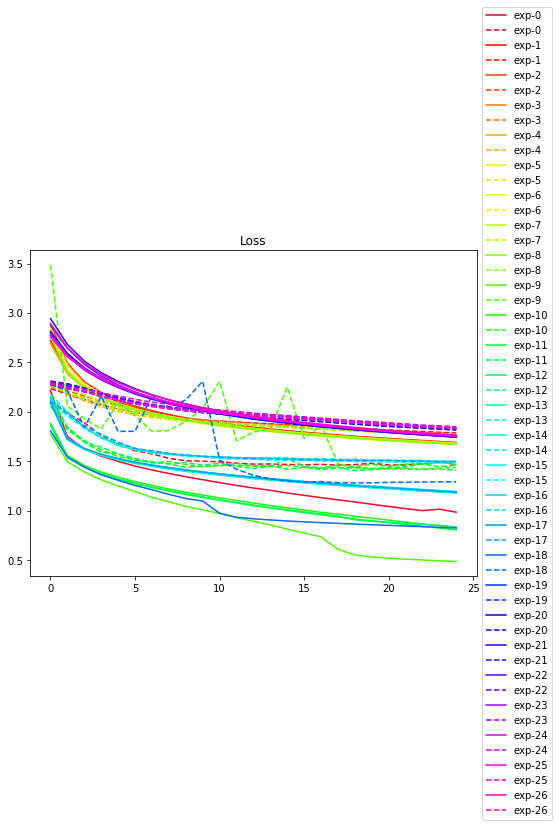

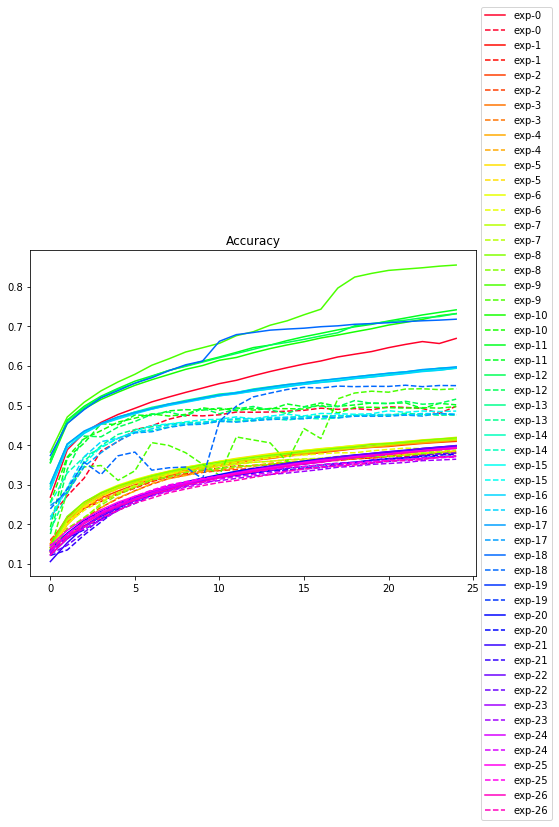

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()